# `compute-perimeter-for-shape-index`
In this notebook the conversion factor is sought for to compare the shape-index computed by the perimeter and area as
$$
\rho = L/\sqrt{A}
$$
with the perimeter computed by the Moore neighbourhood for discrete two-dimensional densities. 

## Goal
Let's say we have a cellular Potts model [1] simulation where the perimeter is computed for cells using the Moore neighbourhood method (MNM) [2], then this perimeter cannot be used to determine the shape index of the cells [3] directly. The MNM perimeter is a count of the pixels that are part of the discrete boundary and therefore needs a conversion to the continuous (Euclidean) perimeter. By comparing the exact perimeters calculated for random shapes, and then discretizing these shapes into pixels and computing the MNM perimeter, we hope to find a conversion factor that allows us to map one into the other. If this works, we can determine a literature-consistent shape-index for discrete shapes such as cellular Potts model cells.

## Method
This notebook presents a pipeline to estimate conversion factors between continuous perimeters and discrete Moore-neighbourhood perimeters. The main steps are:

1. Random shape generation
   - We generate random two-dimensional contours using a truncated Fourier series. 
   - The Fourier coefficients are drawn from a normal distribution and random phase offsets are applied. 
   - The `fourier_series_order` and a `spikeyness_coefficient` control the complexity and amplitude of the shape.

2. Continuous representation
   - A radial function r(θ) is obtained from the Fourier series, and is interpolated with a periodic cubic spline (CubicSpline, from `scipy`) to obtain a smooth representation of the boundary.
   - Using the spline the continuous area $A$ and boundary length $L$ are computed by numerical integration over $\theta$ using Simpson's rule [3].

4. Discrete representation
   - The smooth shape is discretized onto a pixel grid
   - The discrete neighbourhood method for the perimeter is used to compute the perimeter for different boundary orders (single pixel, Moore neighbourhood (8 pixels), and a larger neighbourhood (20 pixels)). 

5. Statistics and conversion factor
   - For each random shape we compute the continuous shape-index $\rho = L/\sqrt{A}$ and the corresponding discrete shape-index using MNM-derived boundaries.
   - Repeating the experiment `samples` times produces distributions of the ratio between continuous and discrete shape-indices. 
   - The mean and standard deviation of these ratios are presented, where the mean is used as the empirical conversion factor.

In [1]:
import sys
sys.path.append('..')

from src.plot import *
from src.shape import *
from src.compute import *  

LaTeX(False)


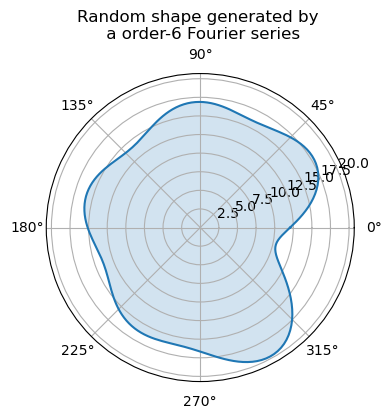

Computed area and boundaries:
-----------------------------
Boundary length:     106.592
Area size:           779.908
Shape-index:           3.817


In [2]:
# Generate a random shape
fourier_series_order = 6
radius, theta = generate_random_shape(
    fourier_series_order = fourier_series_order,
    points_per_shape = 200,
    spikeyness_coefficient = 3.0 # higher means less spikey, lower means more spikey
)
plot_random_shape(theta,radius,fourier_series_order)


# Compute the shape-index by using a spline approximation
random_shape_spline = spline(theta,radius)
area_size, boundary_length = compute_spline_boundary(random_shape_spline, theta)
shape_index = boundary_length/np.sqrt(area_size)

print("Computed area and boundaries:\n-----------------------------")
print(f"Boundary length:   {boundary_length:>9.3f}")
print(f"Area size:         {area_size:>9.3f}")
print(f"Shape-index:       {shape_index:>9.3f}")

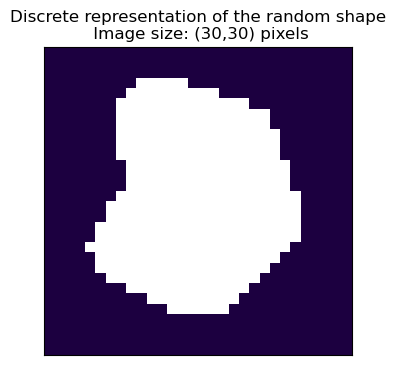

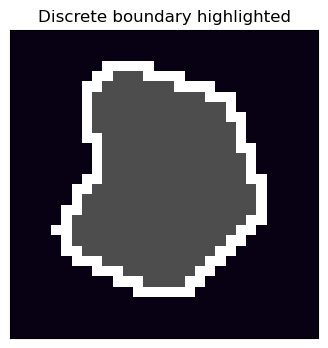

Computed area and boundaries:
-----------------------------
Pixels that are part of the area:                         346
Pixels that are part of the 0th-order boundary:            85
Pixels that are part of the 1st-order boundary:           216
Pixels that are part of the 2nd-order boundary:           790
Shape-index found for 0th-order:                         4.57
Shape-index found for 1st-order:                         11.6
Shape-index found for 2nd-order:                         42.5


In [3]:
# Compute the shape-index by using the Moore neighbourhood

pixel_dimension = 30
grid = discrete_grid_representation(
    radius = radius,
    pixel_dimension = pixel_dimension,
    random_shape_spline = random_shape_spline
)
plot_discrete_grid(grid, pixel_dimension)

# compute area
area_pixels = np.sum(grid)

# compute boundary
boundary, boundary_pixels_order0, boundary_pixels_order1, boundary_pixels_order2 = compute_discrete_boundary(grid, pixel_dimension)
shape_index_order0 = boundary_pixels_order0/np.sqrt(area_pixels)
shape_index_order1 = boundary_pixels_order1/np.sqrt(area_pixels)
shape_index_order2 = boundary_pixels_order2/np.sqrt(area_pixels)

plot_discrete_grid_boundary(grid,boundary)

print("Computed area and boundaries:\n-----------------------------")
print(f"Pixels that are part of the area:                   {area_pixels:>9}")
print(f"Pixels that are part of the 0th-order boundary:     {boundary_pixels_order0:>9}")
print(f"Pixels that are part of the 1st-order boundary:     {boundary_pixels_order1:>9}")
print(f"Pixels that are part of the 2nd-order boundary:     {boundary_pixels_order2:>9}")
print(f"Shape-index found for 0th-order:                    {shape_index_order0:>9.3}")
print(f"Shape-index found for 1st-order:                    {shape_index_order1:>9.3}")
print(f"Shape-index found for 2nd-order:                    {shape_index_order2:>9.3}")


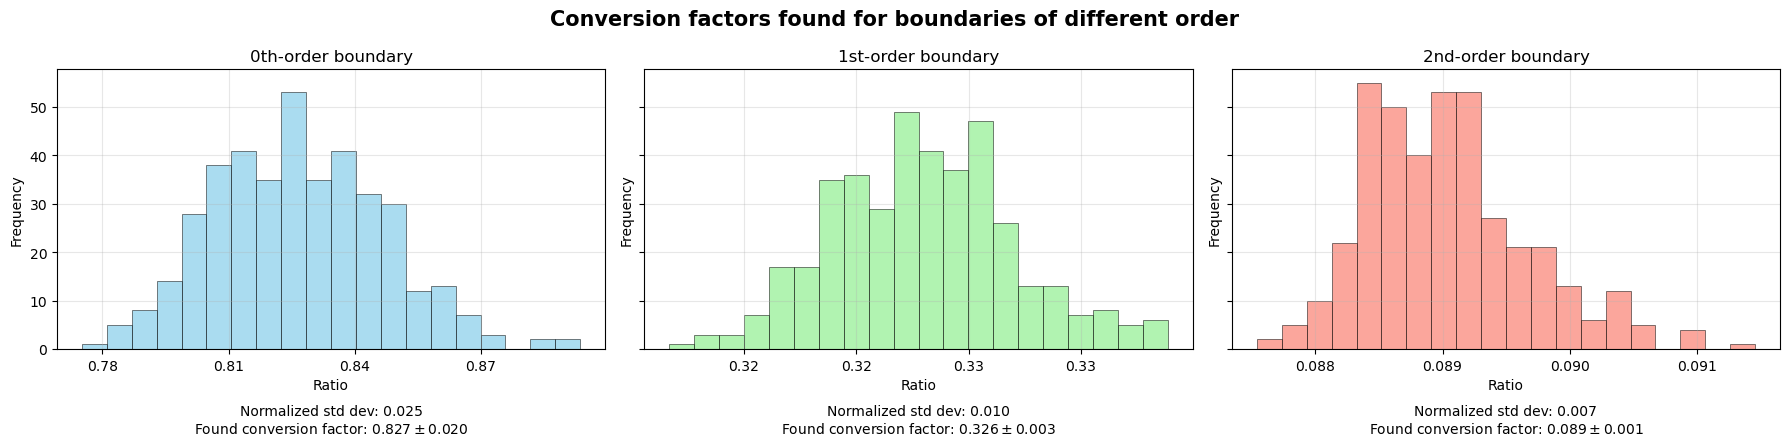

In [4]:
# Statistical analysis

fourier_series_order    = 6
points_per_shape        = 200
spikeyness_coefficient  = 3.0 # higher means less spikey, lower means more spikey
pixel_dimension         = 30
samples                 = 400 

ratio_order0, ratio_order1, ratio_order2 = compute_conversion_ratios(
    fourier_series_order = fourier_series_order,
    points_per_shape = points_per_shape,
    spikeyness_coefficient = spikeyness_coefficient,
    pixel_dimension = pixel_dimension,
    samples = samples
)

plot_conversion_ratios(ratio_order0, ratio_order1, ratio_order2, bins = 20)

## Results
The notebook computes empirical conversion factors that map discrete perimeter-derived shape indices to continuous (Euclidean) shape indices as used in the literature. Below is a summary of the results and their interpretation:
- **Conversion factor**: For each boundary order (0th, 1st, 2nd) we compute the mean of the ratio between the continuous shape-index and the discrete shape-index. The mean is reported in the histograms as the estimated conversion factor.
- **Approximation**: Both the absolute standard deviation and the normalized standard deviation (std / mean) for each ratio distribution are given. The normalized value provides a scale-independent measure of spread and is therefore _the_ indicator for which discrete method is the most precise compared to continuous case.=
- **Recommendation**: As the 1st-order computation is implemented in current software [2], and it is found that the 2nd-order computation does not decrease the normalized standard deviation, the 1st-order Moore neighbourhood method seems to be the best to use.
- **Limitations**:
  - Grid resolution: The conversion factor depends on `pixel_dimension`. Coarser grids introduce discretization errors and larger variance. Consider calibrating conversion factors for the cell sizes used in simulations.
  - Shape ensemble: The experiment samples random Fourier shapes. Conversion factors may differ for shape ensembles with very different statistics (e.g. highly elongated).
  - Small-sample noise: If `samples` is small the mean and standard deviation estimates will be noisy. Increase `samples` for more precise estimates.

## References

[1]: The paper that introduced the model:  [Simulation of biological cell sorting using a two-dimensional extended Potts model](https://doi.org/10.1103/PhysRevLett.69.2013), by François Graner and James A. Glazier.

[2]: This is a method used in many CPM implementations. For example: [Morpheus](https://morpheus.gitlab.io/), [Artistoo](https://artistoo.net/), [gpu-cpm](https://arxiv.org/abs/2312.09317).

[3]: A paper where this quantity is relevant for cells is: [Role of cell deformability in the two-dimensional melting of biological tissues](https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.045602), by Yan-Wei Li and Massimo Pica Ciamarra.

[4]: An established numerical integration method. See: [Wikipedia](https://en.wikipedia.org/wiki/Simpson%27s_rule).